In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [5]:
class config:
    train_sequences_path = "Train/train_sequences.fasta"
    train_labels_path = "Train/train_terms.tsv"
    test_sequences_path = "Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 5
    batch_size = 128
    lr = 0.001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(config.device)

cuda


In [7]:
print("GENERATE TARGETS FOR ENTRY IDS ("+str(config.num_labels)+" MOST COMMON GO TERMS)")
ids = np.load("train_ids.npy")
labels = pd.read_csv(config.train_labels_path, sep = "\t")

top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
labels_names = top_terms[:config.num_labels].index.values
train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()

go_terms_map = {label: i for i, label in enumerate(labels_names)}
labels_matrix = np.empty((len(ids), len(labels_names)))

for index, id in tqdm(enumerate(ids)):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1

labels_list = []
for l in range(labels_matrix.shape[0]):
    labels_list.append(labels_matrix[l, :])

labels_df = pd.DataFrame(data={"EntryID":ids, "labels_vect":labels_list})
labels_df.to_pickle("train_targets_top"+str(config.num_labels)+".pkl")
print("GENERATION FINISHED!")

GENERATE TARGETS FOR ENTRY IDS (500 MOST COMMON GO TERMS)


142246it [00:13, 10272.98it/s]


GENERATION FINISHED!


In [8]:
embeds_map = {
    "ProtBERT" : "protbert-embeddings-for-cafa5",
}

# Length of the different embedding vectors :
embeds_dim = {
    "ProtBERT" : 1024,
}

In [12]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load(datatype+"_embeddings.npy")
            ids = np.load(datatype+"_ids.npy")
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            df_labels = pd.read_pickle(
                "train_targets_top"+str(config.num_labels)+".pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [13]:
dataset = ProteinSequenceDataset(datatype="train",embeddings_source="ProtBERT")

In [14]:
embeddings, labels = dataset.__getitem__(0)
print("COMPONENTS FOR FIRST PROTEIN : ")
print("EMBEDDINGS VECTOR : \n ", embeddings, "\n")
print("TARGETS LABELS VECTOR : \n ", labels, "\n")

COMPONENTS FOR FIRST PROTEIN : 
EMBEDDINGS VECTOR : 
  tensor([ 0.1554,  0.0354,  0.0897,  ..., -0.0395, -0.0736,  0.0459]) 

TARGETS LABELS VECTOR : 
  tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,

In [15]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [16]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):
    
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [18]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 1001/1001 [00:14<00:00, 67.06it/s]


Running Average TRAIN Loss :  138.01013176734153
Running Average TRAIN F1-Score :  0.10499593995876245
Running Average VAL Loss :  135.83309745788574
Running Average VAL F1-Score :  0.1255467728977757


EPOCH  2


100%|██████████| 1001/1001 [00:09<00:00, 106.15it/s]


Running Average TRAIN Loss :  135.19166521497303
Running Average TRAIN F1-Score :  0.13997172384888498
Running Average VAL Loss :  133.9938372884478
Running Average VAL F1-Score :  0.1464107762356954


EPOCH  3


100%|██████████| 1001/1001 [00:09<00:00, 106.59it/s]


Running Average TRAIN Loss :  134.05929635549998
Running Average TRAIN F1-Score :  0.15232792119314145
Running Average VAL Loss :  133.473441192082
Running Average VAL F1-Score :  0.15436065775741423


EPOCH  4


100%|██████████| 1001/1001 [00:09<00:00, 107.20it/s]


Running Average TRAIN Loss :  133.27945722947706
Running Average TRAIN F1-Score :  0.16005326712226772
Running Average VAL Loss :  133.0609187398638
Running Average VAL F1-Score :  0.16080799532522047


EPOCH  5


100%|██████████| 1001/1001 [00:09<00:00, 106.28it/s]


Running Average TRAIN Loss :  132.69335166938774
Running Average TRAIN F1-Score :  0.1660670570798449
Running Average VAL Loss :  132.51075056621008
Running Average VAL F1-Score :  0.1658731808752886


TRAINING FINISHED
FINAL TRAINING SCORE :  0.1660670570798449
FINAL VALIDATION SCORE :  0.1658731808752886


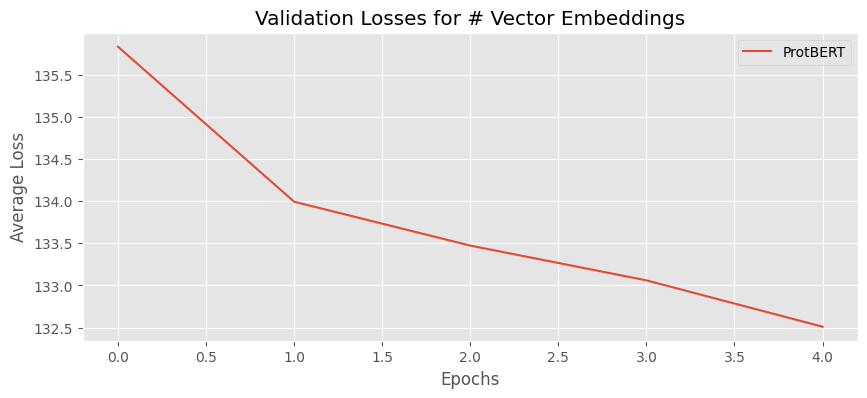

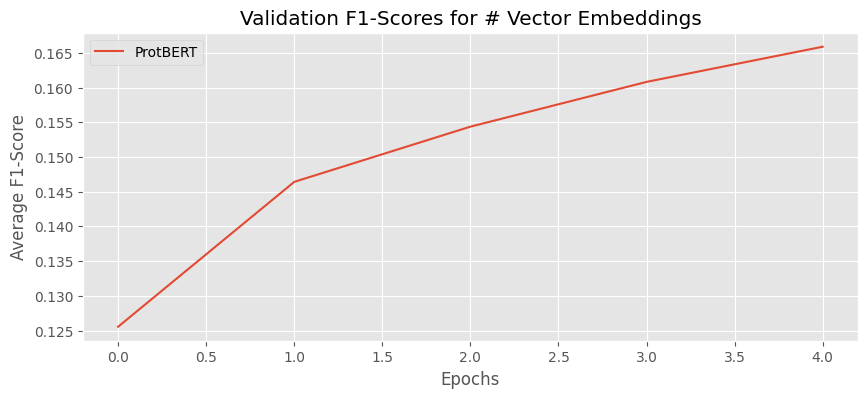

In [19]:
plt.figure(figsize = (10, 4))
plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [20]:
def predict(embeddings_source):
    
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model
        
    model.eval()
    
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [22]:
submission_df = predict("ProtBERT")

GENERATE PREDICTION FOR TEST SET...


141865it [01:01, 2300.05it/s]


PREDICTIONS DONE


In [23]:
submission_df.head(50)

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.903389
1,Q9CQV8,GO:0008150,0.910295
2,Q9CQV8,GO:0110165,0.902997
3,Q9CQV8,GO:0003674,0.891050
4,Q9CQV8,GO:0005622,0.886134
5,Q9CQV8,GO:0009987,0.866747
6,Q9CQV8,GO:0043226,0.868644
7,Q9CQV8,GO:0043229,0.863098
8,Q9CQV8,GO:0005488,0.889404
9,Q9CQV8,GO:0043227,0.853537


In [24]:
len(submission_df)

70932500

In [25]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)